In [116]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import json
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import pandas as pd
import cv2
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [117]:
pth_model1 = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\5x\cropped_images\classification_MODEL1_6_21_2023_all_annotations'
model1 = sorted(os.listdir(pth_model1))
model1 = [im for im in model1 if im.endswith('.tif')]

In [118]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [119]:
model = load_model(r'\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_add_fallopian_test_12_7_23_lr_0.001_epochs_200_pt_40')

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_add_fallopian_test_12_7_23_lr_0.001_epochs_200_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5947798157959067, nms=0.3) 



In [120]:
pthHE = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
pthmasks = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

# not done with all tiles yet
#pthHE_new = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\12_5_new_monkey_tiles'
#pthHE_new_pths = sorted(glob(os.path.join(pthHE_new,'*.tif')))
# = [os.path.basename(pth) for pth in pthHE_new_pths]
#HE_tiles_pths = [name for name in HE_tiles_pths if name[58:] not in pthHE_new_names]

print(len(HE_tiles_pths))

36


In [121]:
HE_tiles = list(map(imread,HE_tiles_pths))
mask_tiles = list(map(imread,mask_tiles_pths))

In [122]:
print(len(HE_tiles))
print(len(mask_tiles))

36
36


In [123]:
HE_tiles_default = [normalize(x) for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles_default = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

HE_tiles = [x/255 for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

In [124]:
mask_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_tiles)]

100%|██████████| 36/36 [00:01<00:00, 19.06it/s]


In [125]:
#PLot image and label for some images - sanity check
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16/2, 8/2))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [126]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

Text(0.5, 1.0, 'Predicted')

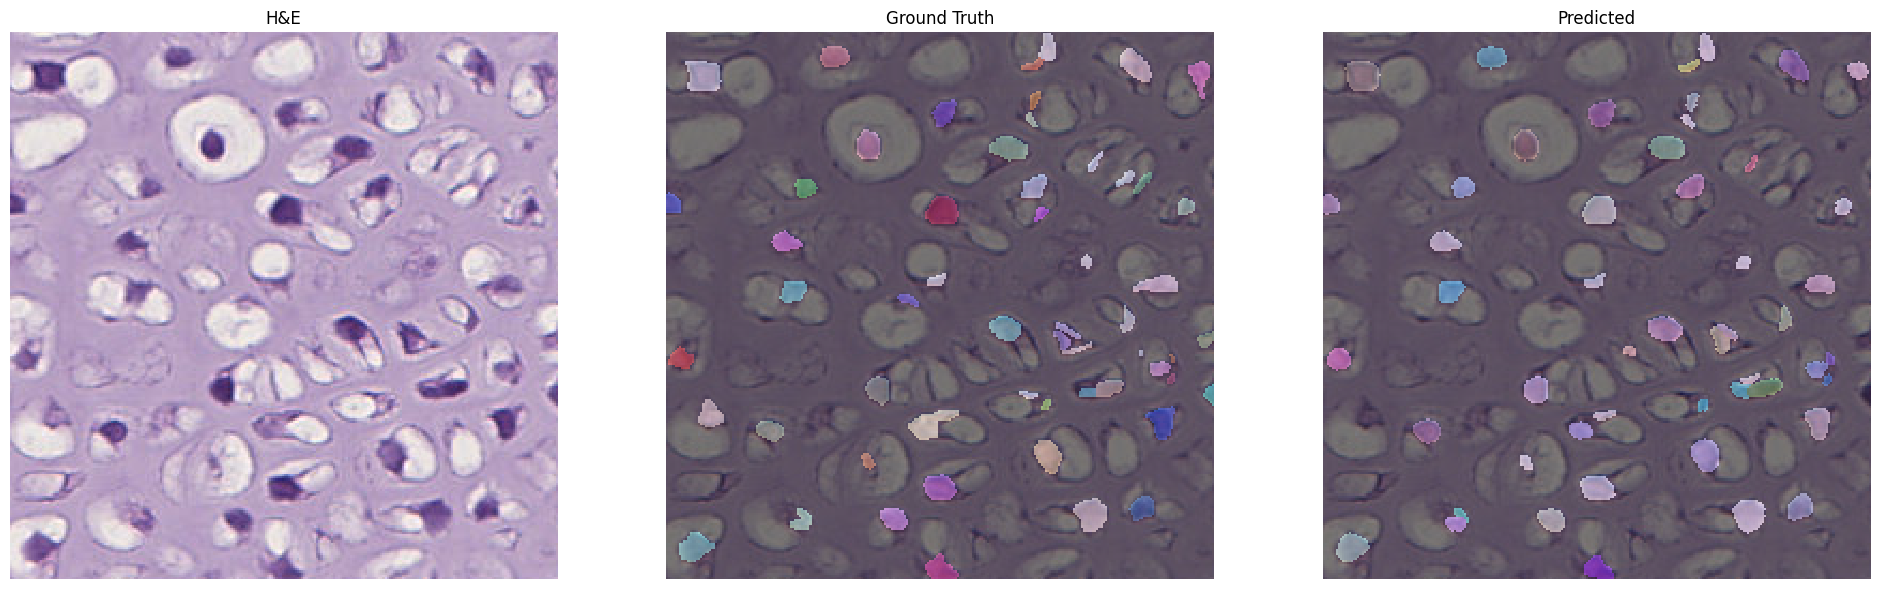

In [127]:
ind = 1

cropped_img = HE_tiles[ind]
cropped_lbl_gt = mask_tiles[ind]
cropped_lbl_pred = mask_val_pred[ind]


fig, ax = plt.subplots(1,3,figsize = (24, 8))
ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl_gt, cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(cropped_img)
ax[2].imshow(cropped_lbl_pred, cmap=lbl_cmap, alpha=0.5)
ax[2].axis('off')
ax[2].set_title('Predicted')

In [128]:
import sys
sys.path.insert(1, r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey')
from scoring_for_donald import TileSetScorer, ScoringSubroutine

nms = [os.path.basename(file) for file in HE_tiles_pths]

# taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
taus = [0.6]

scores = TileSetScorer(nms, mask_tiles, mask_val_pred, taus)

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [129]:
scores.score_set()

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,monkey_fetus_40_0272_eyes1.tif,0.6,0.773515,180,23,18,0.886700,0.909091,0.814480,0.897756,0.826973,0.742420
1,monkey_fetus_40_0273_bone.tif,0.6,0.745884,40,10,16,0.800000,0.714286,0.606061,0.754717,0.810256,0.611514
2,monkey_fetus_40_0281_eyes2.tif,0.6,0.730450,166,40,75,0.805825,0.688797,0.590747,0.742729,0.790991,0.587493
3,monkey_fetus_40_0308_liver1.tif,0.6,0.829868,149,6,6,0.961290,0.961290,0.925466,0.961290,0.845740,0.813001
4,monkey_fetus_40_0323_ears1.tif,0.6,0.699680,166,65,66,0.718615,0.715517,0.558923,0.717063,0.750748,0.538333
5,monkey_fetus_40_0344_brain1.tif,0.6,0.792098,224,38,59,0.854962,0.791519,0.697819,0.822018,0.824776,0.677981
6,monkey_fetus_40_0380_heart1.tif,0.6,0.759185,84,8,7,0.913043,0.923077,0.848485,0.918033,0.811768,0.745230
7,monkey_fetus_40_0381_thymus.tif,0.6,0.824872,144,8,25,0.947368,0.852071,0.813559,0.897196,0.845178,0.758290
8,monkey_fetus_40_0426_lungs.tif,0.6,0.719417,145,42,116,0.775401,0.555556,0.478548,0.647321,0.778109,0.503687
9,monkey_fetus_40_0428_thyroid1.tif,0.6,0.768516,110,18,13,0.859375,0.894309,0.780142,0.876494,0.836160,0.732889


In [130]:
results = scores.score_set()
names = results['Image']

names = [name.split(".")[0][21:] for name in names]

for i in range(len(names)):
    if len(names[i]) > 6:
        names[i] = names[i][:5]

f1_scores = results['F1 Score']

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


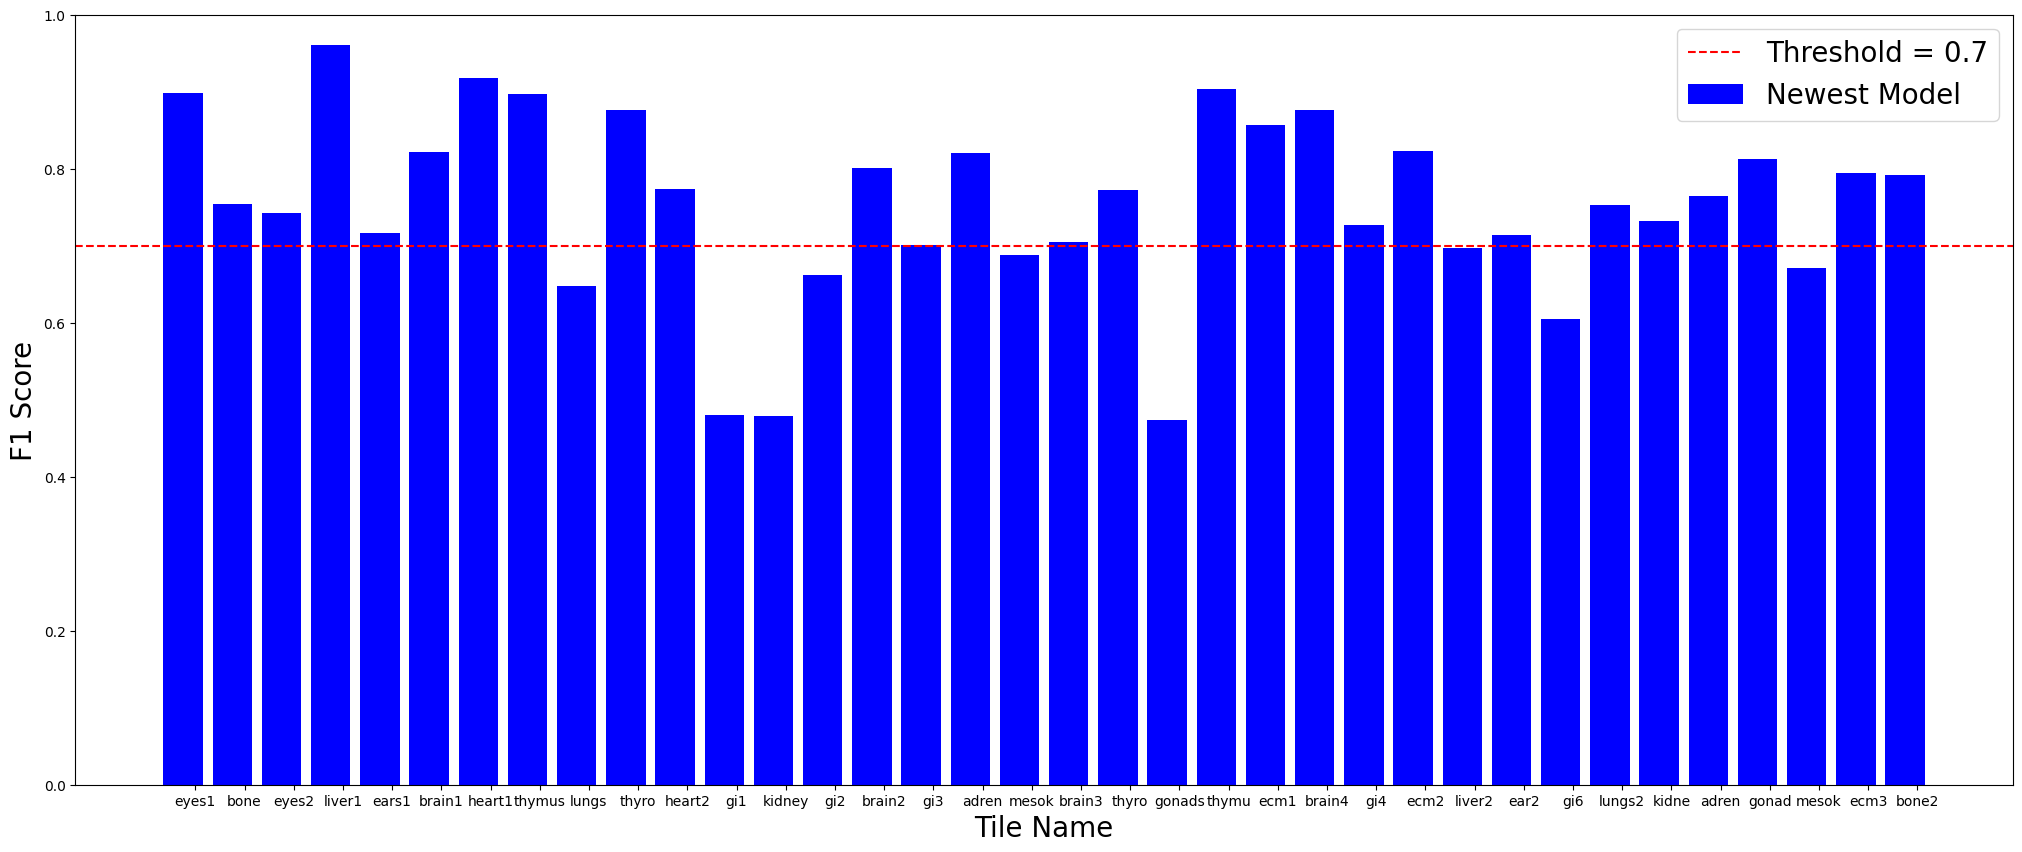

In [131]:
bar_width = 0.25  # Adjust the width of each bar as needed
index = np.arange(len(names))

# Plotting the bars
fig = plt.figure(figsize=(25, 10))
fig.set_facecolor('white')

plt.bar(index, f1_scores, color='blue', label='Newest Model')


plt.xlabel("Tile Name", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
# plt.title("F1 Scores in Testing Tiles (tau = 0.6)", fontsize=28)
plt.axhline(y=0.7, linestyle='--', color='red', label='Threshold = 0.7')
plt.ylim(0, 1)
plt.xticks(index + bar_width, names)  # Set x-axis labels to tile names
plt.legend(fontsize=20)
plt.show()

In [132]:
mask = mask_tiles[0]
centroids = []
for object_id in np.unique(mask)[1:]:
    binary_mask = (mask == object_id)
    x_coords, y_coords = np.where(binary_mask)
    x, y = int(np.round(np.mean(x_coords))), int(np.round(np.mean(y_coords)))
    centroids.append([x, y])
print(len(centroids))

198


In [133]:
df = scores.score_set()
df = df[['Tau', 'IoU', 'TP', 'FP', 'FN', 'F1 Score']]
df['NumCells'] = df['TP'] + df['FN']
df.head()

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Tau,IoU,TP,FP,FN,F1 Score,NumCells
0,0.6,0.773515,180,23,18,0.897756,198
1,0.6,0.745884,40,10,16,0.754717,56
2,0.6,0.730450,166,40,75,0.742729,241
3,0.6,0.829868,149,6,6,0.961290,155
4,0.6,0.699680,166,65,66,0.717063,232


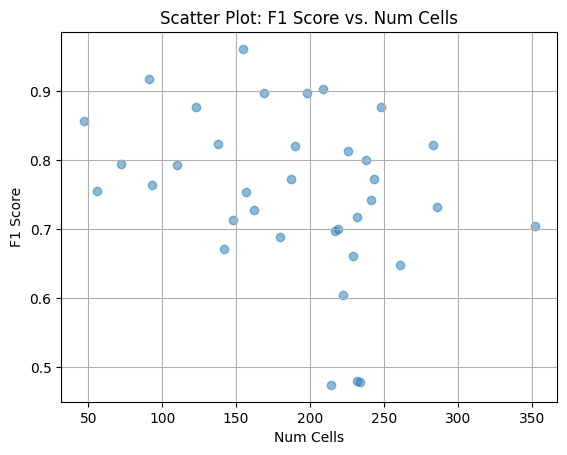

In [134]:
plt.scatter(df['NumCells'], df['F1 Score'], alpha=0.5)
plt.title('Scatter Plot: F1 Score vs. Num Cells')
plt.xlabel('Num Cells')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [135]:
print(HE_tiles_pths[12])
print(HE_tiles_pths[20])
print(HE_tiles_pths[11])

\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles\monkey_fetus_40_0471_kidney.tif
\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles\monkey_fetus_40_0526_gonads.tif
\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles\monkey_fetus_40_0452_gi1.tif


Text(0.5, 1.0, 'Predicted')

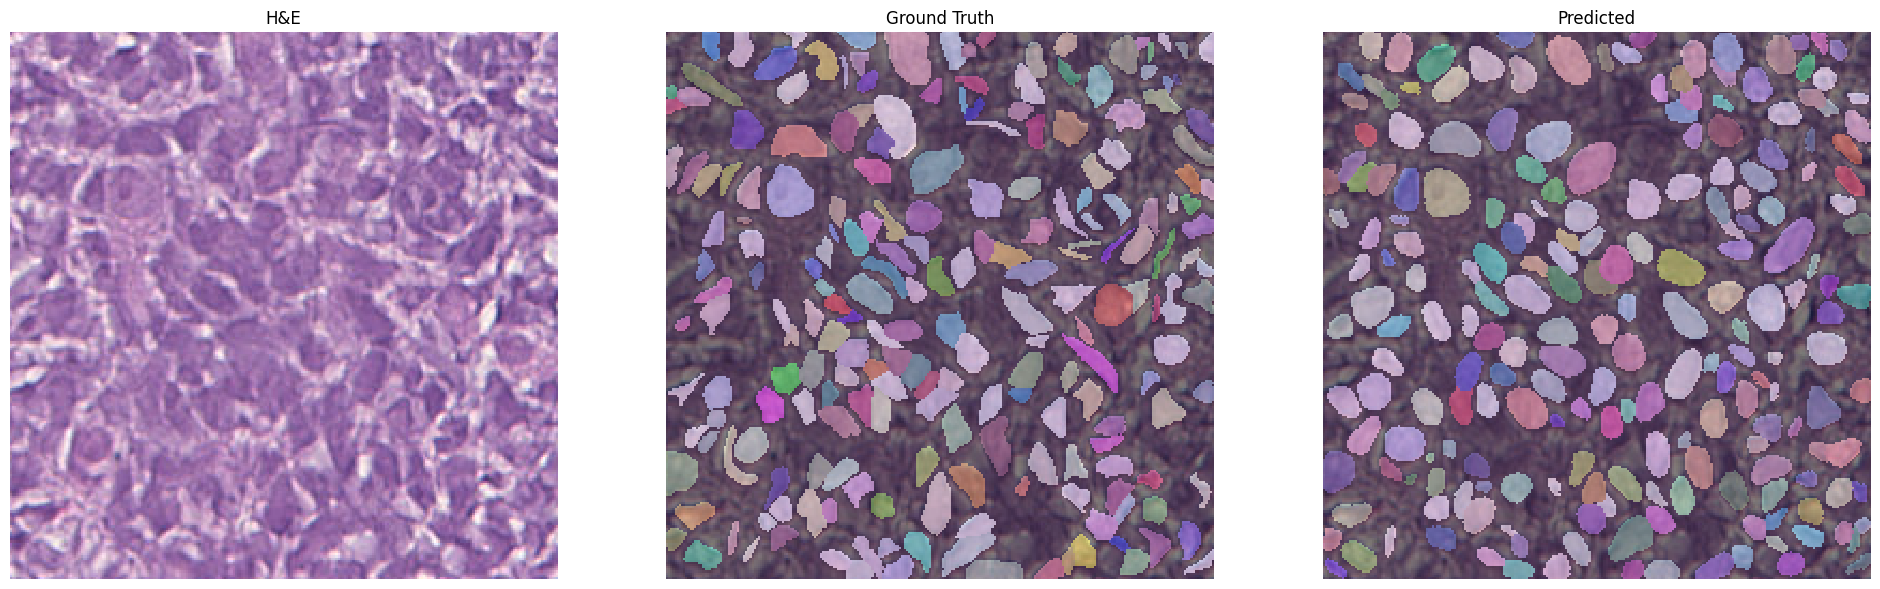

In [136]:
ind = 20

cropped_img = HE_tiles[ind]
cropped_lbl_gt = mask_tiles[ind]
cropped_lbl_pred = mask_val_pred[ind]


fig, ax = plt.subplots(1,3,figsize = (24, 8))
ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('H&E')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbl_gt, cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Ground Truth')

ax[2].imshow(cropped_img)
ax[2].imshow(cropped_lbl_pred, cmap=lbl_cmap, alpha=0.5)
ax[2].axis('off')
ax[2].set_title('Predicted')